# Implementing kmeans from scratch

In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
import matplotlib.pyplot as plt

In [53]:
from sklearn.datasets import make_blobs

In [54]:
from IPython.display import clear_output
import time

In [55]:
k, n = 3, 2

In [64]:
X, y = make_blobs(n_samples=10, centers=k, n_features=n, random_state=0, 
                  cluster_std=4)

In [65]:
y

array([0, 0, 1, 0, 2, 2, 2, 1, 1, 0])

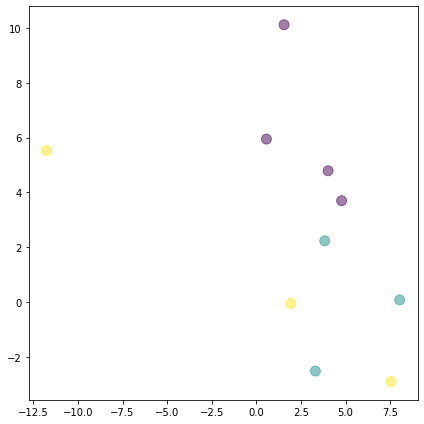

In [66]:
fig, ax = plt.subplots(figsize=(6, 6), ncols=1)
ax.scatter(X[:,0], X[:,1], s=100, alpha=.5, c=y)
plt.tight_layout()
plt.show()

In [9]:
k = 3

In [10]:
centroids = np.random.rand(k, n)

In [11]:
centroids

array([[0.05851585, 0.05463378],
       [0.28812596, 0.22558363],
       [0.28476359, 0.74965099]])

In [12]:
from sklearn.metrics.pairwise import euclidean_distances

In [13]:
def update(M):
    c = M.mean(axis=0)
    rss = np.power(euclidean_distances(c.reshape(1, -1), 
                                       M)[0], 2).sum()
    return c, rss

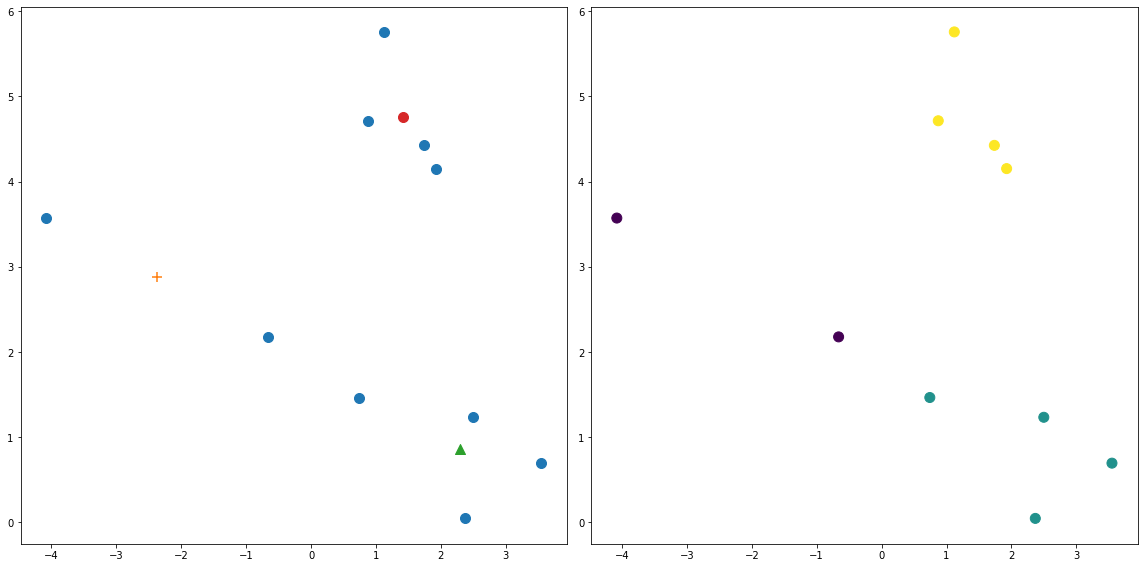

In [14]:
RSS = []

for iteration in range(20):
    
    clear_output(wait=True)

    D = euclidean_distances(centroids, X)
    y_pred = D.T.argmin(axis=1)

    markers = ['+', '^', 'o']
    fig, ax = plt.subplots(figsize=(16, 8), ncols=2)
    ax[0].scatter(X[:,0], X[:,1], s=100, alpha=1.0)
    ax[1].scatter(X[:,0], X[:,1], c=y_pred, s=100, alpha=1.0)
    for i, c in enumerate(centroids):
        ax[0].scatter(c[0], c[1], s=100, marker=markers[i])
    plt.tight_layout()
    plt.show()

    assignment = {}
    for i, c in enumerate(centroids):
        assignment[i] = []
        for j, f in enumerate(y_pred):
            if f == i:
                assignment[i].append(X[j])
    A = {}
    for p, v in assignment.items():
        A[p] = np.array(v)

    irss = 0
    for z, w in A.items():
        if w.shape[0] == 0:
            pass
        else:
            nc, rss = update(w)
            irss += rss
            centroids[z] = nc
    RSS.append(irss)
    time.sleep(1)


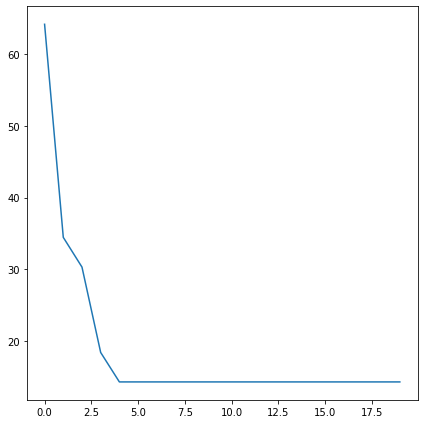

In [15]:
fig, ax = plt.subplots(figsize=(6, 6), ncols=1)
ax.plot(RSS)
plt.tight_layout()
plt.show()

In [16]:
y_pred

array([2, 2, 1, 2, 0, 1, 0, 1, 1, 2])

In [17]:
y

array([0, 0, 1, 0, 2, 2, 2, 1, 1, 0])

In [36]:
tp, fp, fn, tn = 0, 0, 0, 0
for i, c in enumerate(y_pred):
    y_true_i = y[i]
    for j, z in enumerate(y_pred[i+1:]):
        s = j + i + 1
        y_true_j = y[s]
        if c == z:
            if y_true_i == y_true_j:
                tp += 1
            else:
                fp += 1
        else:
            if y_true_i == y_true_j:
                fn += 1
            else:
                tn += 1

In [37]:
print(tp, fp, fn, tn)

10 3 2 30


In [38]:
tp / (tp + fp)

0.7692307692307693

In [39]:
(tp + tn) / (tp + fp + fn + tn)

0.8888888888888888

## Implementazione sklearn

In [4]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

In [60]:
kmeans = KMeans(n_clusters=3)
aggc = AgglomerativeClustering(n_clusters=3)

In [61]:
y_pred_k = kmeans.fit_predict(X)
y_pred_a = aggc.fit_predict(X)

In [62]:
print(y_pred_k)
print(y_pred_a)

[0 0 1 0 1 1 2 1 1 0]
[2 2 0 2 0 0 1 0 0 2]


In [63]:
benchmark = {'Kmeans': KMeans(n_clusters=3), 
             'Agglomerative': AgglomerativeClustering(n_clusters=3)}
results = []
for name, alg in benchmark.items():
    res = results.append(alg.fit_predict(X))
    print(name, adjusted_rand_score(y, y_pred))

Kmeans 0.7232472324723247
Agglomerative 0.7232472324723247


## Real example

In [5]:
data_file = 'data/fifa/players_20.csv'
P = pd.read_csv(data_file, index_col=0, usecols=range(77))

In [30]:
X = P[['height_cm', 'value_eur']]

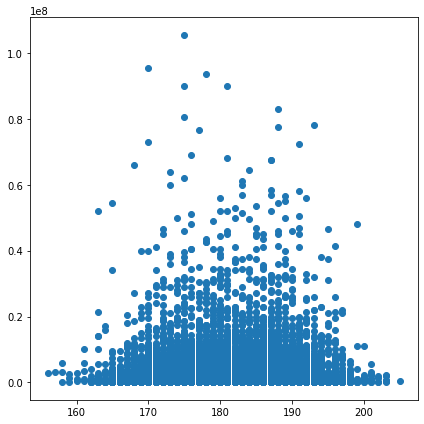

In [32]:
fig, ax = plt.subplots(figsize=(6, 6), ncols=1)
ax.scatter(X.height_cm, X.value_eur)
plt.tight_layout()
plt.show()

In [33]:
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(X)

In [34]:
def select_points(X, y, cluster):
    pos = [i for i, x in enumerate(y) if x == cluster]
    return X.iloc[pos]

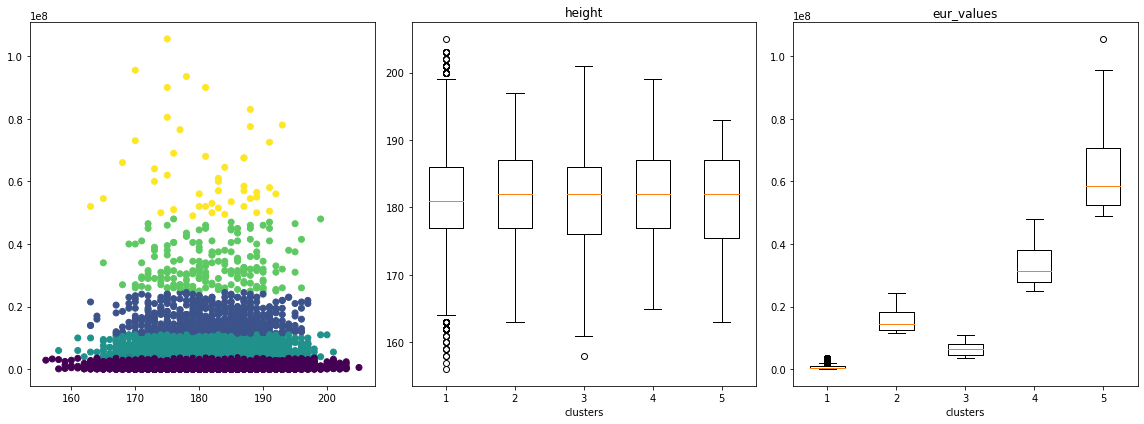

In [37]:
clusters = [select_points(X, y, c) for c in range(5)]
eur_values = np.array([x.value_eur.values for x in clusters], dtype='object')
h_values = np.array([x.height_cm.values for x in clusters], dtype='object')
fig, ax = plt.subplots(figsize=(16, 6), ncols=3, nrows=1)
ax[0].scatter(X.height_cm, X.value_eur, c=y)
ax[1].boxplot(h_values)
ax[1].set_xlabel('clusters')
ax[1].set_title('height')
ax[2].boxplot(eur_values)
ax[2].set_xlabel('clusters')
ax[2].set_title('eur_values')
plt.tight_layout()
plt.show()

## Scaling data

In [48]:
from sklearn.preprocessing import StandardScaler

In [49]:
Xs = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

In [50]:
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(Xs)

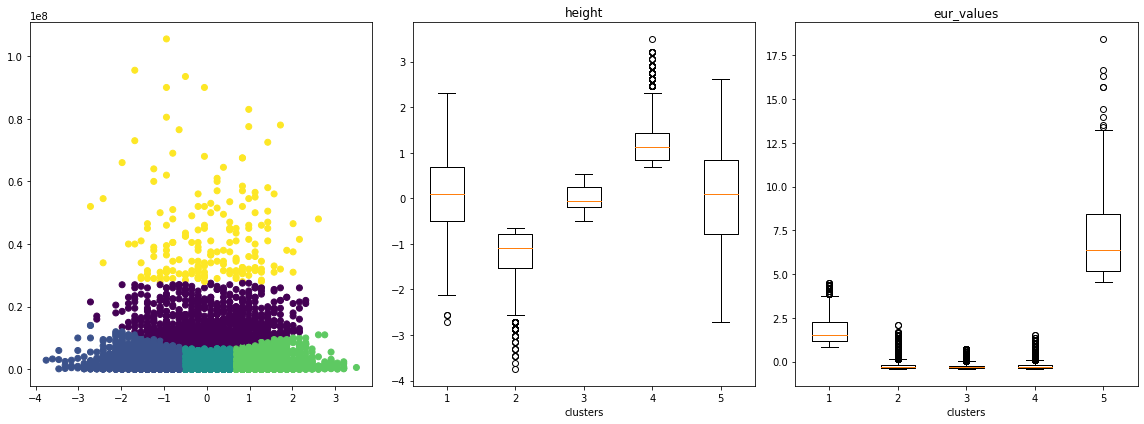

In [51]:
clusters = [select_points(Xs, y, c) for c in range(5)]
eur_values = np.array([x.value_eur.values for x in clusters], dtype='object')
h_values = np.array([x.height_cm.values for x in clusters], dtype='object')
fig, ax = plt.subplots(figsize=(16, 6), ncols=3, nrows=1)
ax[0].scatter(Xs.height_cm, X.value_eur, c=y)
ax[1].boxplot(h_values)
ax[1].set_xlabel('clusters')
ax[1].set_title('height')
ax[2].boxplot(eur_values)
ax[2].set_xlabel('clusters')
ax[2].set_title('eur_values')
plt.tight_layout()
plt.show()